# 1. Load dataset

In [1]:
import os
from co_datasets.tsp_graph_dataset import TSPGraphDataset

dataset = TSPGraphDataset(
    data_file=os.path.join("./", "tsp50_concorde.txt"),
    sparse_factor=-1,
)


Loaded "./tsp50_concorde.txt" with 100 lines


In [2]:
idx, points, adj_matrix, tour = dataset[0]
print(idx.shape, points.shape, adj_matrix.shape, tour.shape)

torch.Size([1]) torch.Size([50, 2]) torch.Size([50, 50]) torch.Size([51])


# 2. Calculate Observation times (based on FI)

In [3]:
import torch.nn as nn
import torch
import numpy as np
from matplotlib import pyplot as plt

tEnd = 10.
T = 1000

from scipy.optimize import bisect

def f(x):
    return np.log(x/(1-x))

xEnd = np.exp(-tEnd)
fGrid = np.linspace(-f(xEnd), f(xEnd), T)
xGrid = np.array([bisect(lambda x: f(x)-fGrid[i], xEnd/2, 1-xEnd/2) for i in range(T)])
observationTimes = -np.log(xGrid)    

### Analytically derived reverse-time transition rate
num_states = 2 # state space spans only zero and one
brTable = np.zeros((num_states, num_states, T))
for tIndex in range(T):
    p = np.exp(-observationTimes[tIndex])
    for n in range(num_states):
        for m in range(n):
            brTable[n, m, tIndex] = n-m 

### Analytical forward solution, PDF
from scipy.stats import binom

support = np.arange(0, num_states)
solArray = np.zeros((T+1, num_states, num_states))
solArray[0,:,:] = np.eye(num_states)

for tIndex in range(T):
    p = np.exp(-observationTimes[tIndex])
    for initial_condition in range(num_states):
        solArray[tIndex + 1, :, initial_condition] =  binom(initial_condition, p).pmf(support)    
        
### Analytical forward solution, CDF
cumSolArray = np.zeros_like(solArray)

for i in range(T+1):
    for j in range(num_states):
        cumSolArray[i, :, j] = np.cumsum(solArray[i, :, j])    

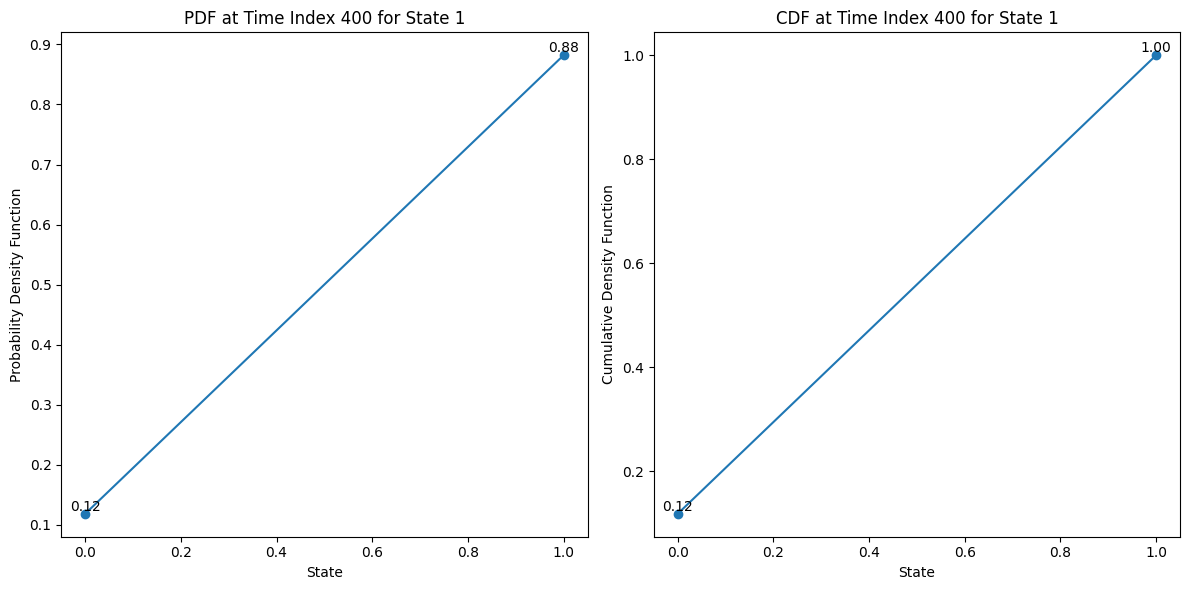

In [4]:
time_index = 400
state = 1

pdf_at_time = solArray[time_index, :, state]
cdf_at_time = cumSolArray[time_index, :, state]

plt.figure(figsize=(12, 6))

# PDF plot
plt.subplot(1, 2, 1)
plt.plot(np.arange(len(pdf_at_time)), pdf_at_time, marker='o')
plt.title(f'PDF at Time Index {time_index} for State {state}')
plt.xlabel('State')
plt.ylabel('Probability Density Function')

# Adding y-values on the PDF plot
for i, value in enumerate(pdf_at_time):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

# CDF plot
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(cdf_at_time)), cdf_at_time, marker='o')
plt.title(f'CDF at Time Index {time_index} for State {state}')
plt.xlabel('State')
plt.ylabel('Cumulative Density Function')

# Adding y-values on the CDF plot
for i, value in enumerate(cdf_at_time):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


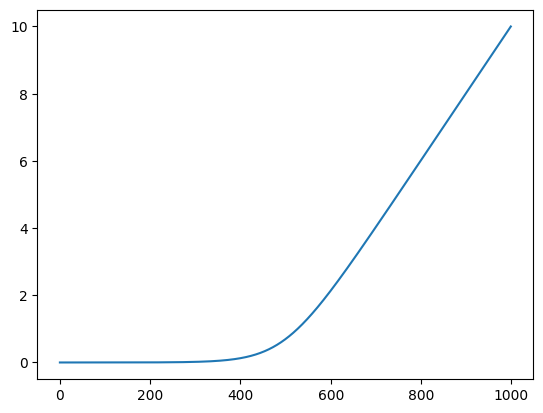

In [5]:
plt.plot(observationTimes)

In [6]:
brTable = brTable.ravel()

def forward_process(x_0, T):
    with torch.no_grad():
        node_size, _ = x_0.shape
        tIndex = np.random.choice(T, size=(1, 1), p=[1/T]*T)
        
        cp = cumSolArray[(tIndex + 1), :, x_0]
        u = np.random.uniform(low=0.0, high=1.0, size=(node_size, node_size, 1))
        x_t =  np.argmax((u < cp), axis = -1)

        birthRate_t = brTable[x_0 * 2 * T + x_t * T + tIndex]
        
        return x_t, birthRate_t, tIndex[:, 0]

In [7]:
brTable = brTable.ravel()

def forward_process(x_0, t):
    with torch.no_grad():
        node_size, _ = x_0.shape
        tIndex = np.full((1, 1), t)  # Create an array with shape (1, 1) and value t

        cp = cumSolArray[(tIndex + 1), :, x_0]
        u = np.random.uniform(low=0.0, high=1.0, size=(node_size, node_size, 1))
        x_t =  np.argmax((u < cp), axis = -1)

        birthRate_t = brTable[x_0 * 2 * T + x_t * T + tIndex]
        
        return x_t, birthRate_t, tIndex[:, 0]

Animation saved as ./graph_animation.gif


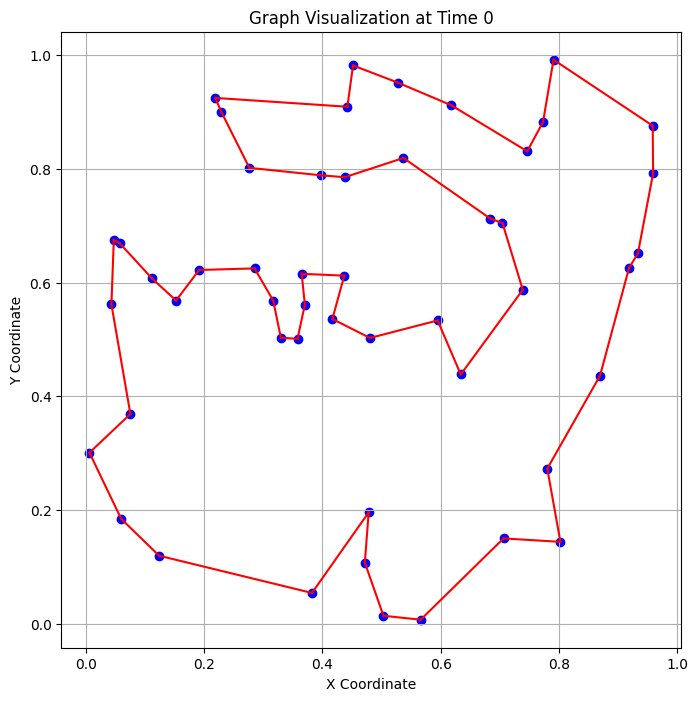

In [9]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

adj_matrices = []
for t in range(T):
    adj_matrix_t, birthRate_t, tIndex = forward_process(adj_matrix, t)
    adj_matrices.append(adj_matrix_t.astype(int))

# Animation
fig, ax = plt.subplots(figsize=(8, 8))

def update(frame):
    ax.clear()
    adj_matrix_t = adj_matrices[frame]
    
    # Plot points
    ax.scatter(points[:, 0], points[:, 1], c='blue', marker='o')
    
    # Plot edges based on adjacency matrix
    num_points = points.shape[0]
    for i in range(num_points):
        for j in range(0, num_points):  # Avoid repeating edges and self-loops
            if adj_matrix_t[i, j] == 1:
                start_point = points[i]
                end_point = points[j]
                ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], c='red')
    
    ax.set_title(f'Graph Visualization at Time {frame}')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.grid(True)

ani = FuncAnimation(fig, update, frames=range(T), repeat=True)

# Save animation as GIF
gif_path = "./graph_animation.gif"
ani.save(gif_path, writer=PillowWriter(fps=100))

print(f"Animation saved as {gif_path}")